Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed: int = 2024
    do_display: bool = True
    result_fname: str = ""
    m_train_examples: int = 1000
    m_test_examples: int = 1000
    score_name: str = "y"
    clean_up: bool = False
    show_console: bool = False
    generative_noise_scale: float = 0.87
    scoring_noise_scale: float = 2.0
    continue_inspection_probability: float = 0.8

In [2]:
# set up Python
import logging
import os
import json
from itertools import product
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from wvu.util import plot_roc, threshold_plot
from plotnine import *

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name: str = "small example"

In [5]:
if do_display:
    print(example_name)

small example


In [6]:
# read data and set scale of system


examples_frame = pd.read_csv("d_large.csv")

examples_frame

,x1,x2,y,presentation_group,sampled_positive
0,1.038658,0.008663,1,1,False
1,0.055176,0.827693,1,1,False
2,-0.183270,1.003654,1,1,True
3,1.048862,-0.208270,0,1,False
4,-0.130628,0.094156,0,1,False
...,...,...,...,...,...
999995,-0.051125,0.004166,0,200000,False
999996,1.217447,0.174052,0,200000,False
999997,0.987780,0.041584,1,200000,False
999998,0.059343,1.083677,1,200000,True


In [7]:
variable_names = [c for c in examples_frame.columns if c.startswith('x')]
n_item_features: int = len(variable_names)
group_sizes = examples_frame.groupby('presentation_group').size()
n_alternatives: int = int(np.max(group_sizes))
assert np.all(group_sizes == n_alternatives)

In [8]:
def mk_example(
    *,
    m_examples: int,
):
    groups = sorted(set(examples_frame['presentation_group']))
    sample = rng.choice(groups, size=m_examples, replace=True)
    return (
        examples_frame
            .loc[np.isin(examples_frame['presentation_group'], sample), :]
            .sort_values(
                ['presentation_group', 'sampled_positive', 'y'], 
                ascending=[True, False, False],
                ignore_index=True, 
                inplace=False,
            )
    )

In [9]:
observations_train = mk_example(m_examples=m_train_examples)

observations_train.head()

,x1,x2,y,presentation_group,sampled_positive
0,0.124434,1.093304,1,116,True
1,1.150784,0.071900,1,116,False
2,1.298226,0.049298,1,116,False
3,0.018783,0.914060,1,116,False
4,0.084244,0.003521,0,116,False


In [10]:

observations_test = mk_example(m_examples=m_test_examples)

observations_test.head()


,x1,x2,y,presentation_group,sampled_positive
0,-0.030772,0.914600,1,179,True
1,1.012660,-0.003719,1,179,False
2,-0.027100,-0.214783,0,179,False
3,0.225265,0.095680,0,179,False
4,-0.315568,-0.150670,0,179,False


Try a direct logistic regression on the uncensored proposed choices.

In [11]:
model_logistic_1 = LogisticRegression()
model_logistic_1.fit(
    observations_train.loc[:, variable_names],
    observations_train[score_name]
)
observations_test['unobservable_logistic_prediction'] = model_logistic_1.predict_proba(
    observations_test.loc[:, variable_names])[:, 1]

observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction
0,-0.030772,0.914600,1,179,True,0.680026
1,1.012660,-0.003719,1,179,False,0.386532
2,-0.027100,-0.214783,0,179,False,0.313171
3,0.225265,0.095680,0,179,False,0.412534
4,-0.315568,-0.150670,0,179,False,0.330070


<Figure size 640x480 with 0 Axes>

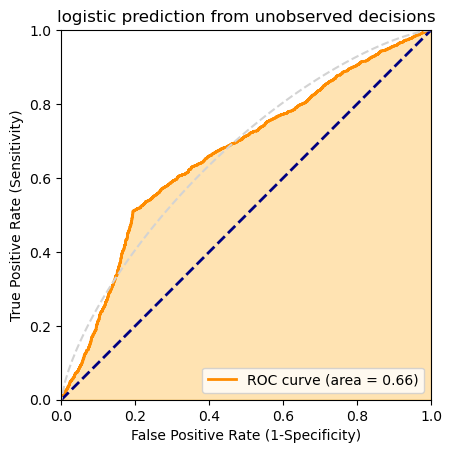

0.6644508571342439

In [12]:
plot_roc(
    prediction=observations_test["unobservable_logistic_prediction"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="logistic prediction from unobserved decisions",
)

Try a direct logistic prediction choices limited down to at most best one per group.


In [33]:
model_logistic_2 = LogisticRegression()
model_logistic_2.fit(
    observations_train.loc[:, variable_names],
    observations_train[score_name] * observations_train['sampled_positive'],
    sample_weight=10 * observations_train[score_name] * observations_train['sampled_positive'] + 1.0
)
observations_test['censored_logistic_prediction'] = model_logistic_2.predict_proba(
    observations_test.loc[:, variable_names])[:, 1]

observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction,censored_logistic_prediction,Stan_score
0,-0.030772,0.914600,1,179,True,0.680026,0.872680,0.867266
1,1.012660,-0.003719,1,179,False,0.386532,0.387414,0.379589
2,-0.027100,-0.214783,0,179,False,0.313171,0.288788,0.275928
3,0.225265,0.095680,0,179,False,0.412534,0.463789,0.450761
4,-0.315568,-0.150670,0,179,False,0.330070,0.327995,0.312713


<Figure size 640x480 with 0 Axes>

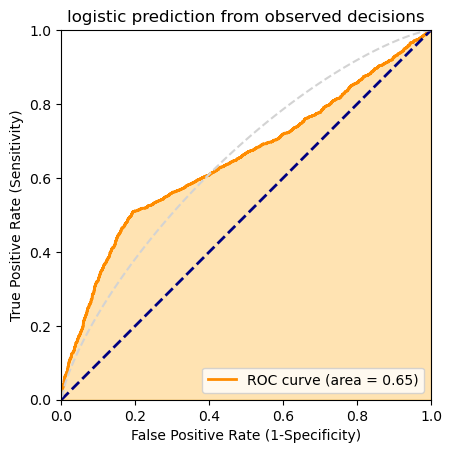

0.6479928790493512

In [34]:
plot_roc(
    prediction=observations_test["censored_logistic_prediction"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="logistic prediction from observed decisions",
)

Try a Stan to try and represent the selection presentation process.

In [15]:
# (for now) limit down to groups with a positive
groups_with_positive = (
    observations_train
        .groupby(['presentation_group'])
        ['sampled_positive']
        .max()
        .reset_index(drop=False, inplace=False)
)
groups_with_positive = list(
    groups_with_positive.loc[groups_with_positive['sampled_positive'], 'presentation_group']
)
observations_train_pos = (
    observations_train
        .loc[np.isin(observations_train['presentation_group'], groups_with_positive), :]
        .reset_index(drop=True, inplace=False)
        .sort_values(
            ['presentation_group', 'sampled_positive', 'y'], 
            ascending=[True, False, False],
            ignore_index=True, 
            inplace=False,
        )
)


In [16]:
observations_train_pos

,x1,x2,y,presentation_group,sampled_positive
0,0.124434,1.093304,1,116,True
1,1.150784,0.071900,1,116,False
2,1.298226,0.049298,1,116,False
3,0.018783,0.914060,1,116,False
4,0.084244,0.003521,0,116,False
...,...,...,...,...,...
4755,0.060464,0.989842,1,199275,True
4756,0.077070,0.934263,1,199275,False
4757,0.817627,-0.104491,0,199275,False
4758,0.164064,0.053453,0,199275,False


In [17]:
def define_Stan_list_src(
    n_alternatives: int,
):
    stan_model_list_src = (f"""
data {{
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower={n_alternatives}, upper={n_alternatives}> n_alternatives;  // number of items per presentation list
  int<lower=1> m_examples;  // number of examples
  matrix[m_examples, n_vars] x_picked;  // character of picked examples
"""
        + "".join(
            [
                f"""  matrix[m_examples, n_vars] x_passed_{i};  // character of passed examples
"""
                for i in range(1, n_alternatives)
            ]
        )
        + f"""}}
parameters {{
  real beta_0;  // model parameters
  vector[n_vars] beta;  // model parameters
}}
transformed parameters {{
  vector[m_examples] p_picked_link;  // indication probability of picked item
  array[n_alternatives-1] vector[m_examples] p_passed_links;  // indication probabilities of passed items
  p_picked_link = beta_0 + x_picked * beta;
"""
        + "".join(
            [
                f"""  p_passed_links[{sel_j}] = beta_0 + x_passed_{sel_j} * beta;  // modeled expected score of passed item
"""
                for sel_j in range(1, n_alternatives)
            ]
        )
        + f"""}}
model {{
    // basic priors
  beta_0 ~ normal(0, 10);
  beta ~ normal(0, 10);
    // log probability of observed situation
  target += 10 * log(inv_logit(p_picked_link));  // chosen item should have a high probability
  for (sel_j in 1:(n_alternatives-1)) {{
    // target += normal_lcdf(p_picked_link | p_passed_links[sel_j], 0.1);  // chosen item should be maximal
     target += log1m(inv_logit(p_passed_links[sel_j]));
  }}
}}
"""
    )
    return stan_model_list_src

stan_model_src = define_Stan_list_src(n_alternatives=n_alternatives)

print(stan_model_src)


data {
  int<lower=1> n_vars;  // number of variables per alternative
  int<lower=5, upper=5> n_alternatives;  // number of items per presentation list
  int<lower=1> m_examples;  // number of examples
  matrix[m_examples, n_vars] x_picked;  // character of picked examples
  matrix[m_examples, n_vars] x_passed_1;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_2;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_3;  // character of passed examples
  matrix[m_examples, n_vars] x_passed_4;  // character of passed examples
}
parameters {
  real beta_0;  // model parameters
  vector[n_vars] beta;  // model parameters
}
transformed parameters {
  vector[m_examples] p_picked_link;  // indication probability of picked item
  array[n_alternatives-1] vector[m_examples] p_passed_links;  // indication probabilities of passed items
  p_picked_link = beta_0 + x_picked * beta;
  p_passed_links[1] = beta_0 + x_passed_1 * beta;  // modeled expected score of

In [18]:
def format_Stan_data(
):
    m_lists = int(observations_train_pos.shape[0] / n_alternatives)

    def fmt_x_block(sel_j: int):
        x_block = observations_train_pos.loc[
            [sel_j + n_alternatives * group_i for group_i in range(m_lists)], 
            variable_names]
        return json.dumps([list(v) for v in list(np.array(x_block))])

    data_str = (f"""
{{
 "n_vars" : {n_item_features},
 "n_alternatives" : {n_alternatives},
 "m_examples" : {m_lists},
 "x_picked" : {fmt_x_block(0)},
"""
    + ",\n".join([f' "x_passed_{sel_j}" : {fmt_x_block(sel_j)}' for sel_j in range(1, n_alternatives)])
    + """
}
""")
    return data_str

data_str = format_Stan_data()

# print(data_str)

In [19]:
def run_stan_model(
    stan_model_src: str,
    *,
    data_str: str,
    clean_up: bool = True,
    model_note: str = '',
    show_progress: bool = False,
    show_console: bool = False,
):
    # build model
    # export source and data
    stan_file = f"rank_src_{model_note}_tmp.stan"
    data_file = f"rank_data_{model_note}_tmp.json"
    with open(stan_file, "w", encoding="utf8") as file:
        file.write(stan_model_src)
    with open(data_file, "w", encoding="utf8") as file:
        file.write(data_str)
    # instantiate the model object
    model_comp = CmdStanModel(stan_file=stan_file)
    # fit to data
    fit = model_comp.sample(
        data=data_file,
        show_progress=show_progress,
        show_console=show_console,
    )
    if clean_up:
        os.remove(stan_file)
        os.remove(data_file)
    return fit

In [20]:
fit = run_stan_model(
    stan_model_src=stan_model_src,
    data_str=data_str,
    model_note='small_test',
)

In [21]:
draws = fit.draws_pd(vars=['lp__', 'beta_0', 'beta'])

draws

,lp__,beta_0,beta[1],beta[2]
0,-6047.49,-0.471905,-0.015247,2.53845
1,-6048.80,-0.435444,0.012221,2.50931
2,-6049.04,-0.421548,-0.041839,2.57729
3,-6052.83,-0.253484,-0.200267,2.41327
4,-6050.33,-0.282431,-0.197304,2.40968
...,...,...,...,...
3995,-6047.06,-0.422258,-0.057004,2.52165
3996,-6047.49,-0.479726,-0.002888,2.55501
3997,-6047.78,-0.478780,-0.029081,2.58417
3998,-6048.03,-0.473115,-0.023575,2.59897


In [22]:
draws.mean()

lp__      -6048.457290
beta_0       -0.423154
beta[1]      -0.058332
beta[2]       2.513037
dtype: float64

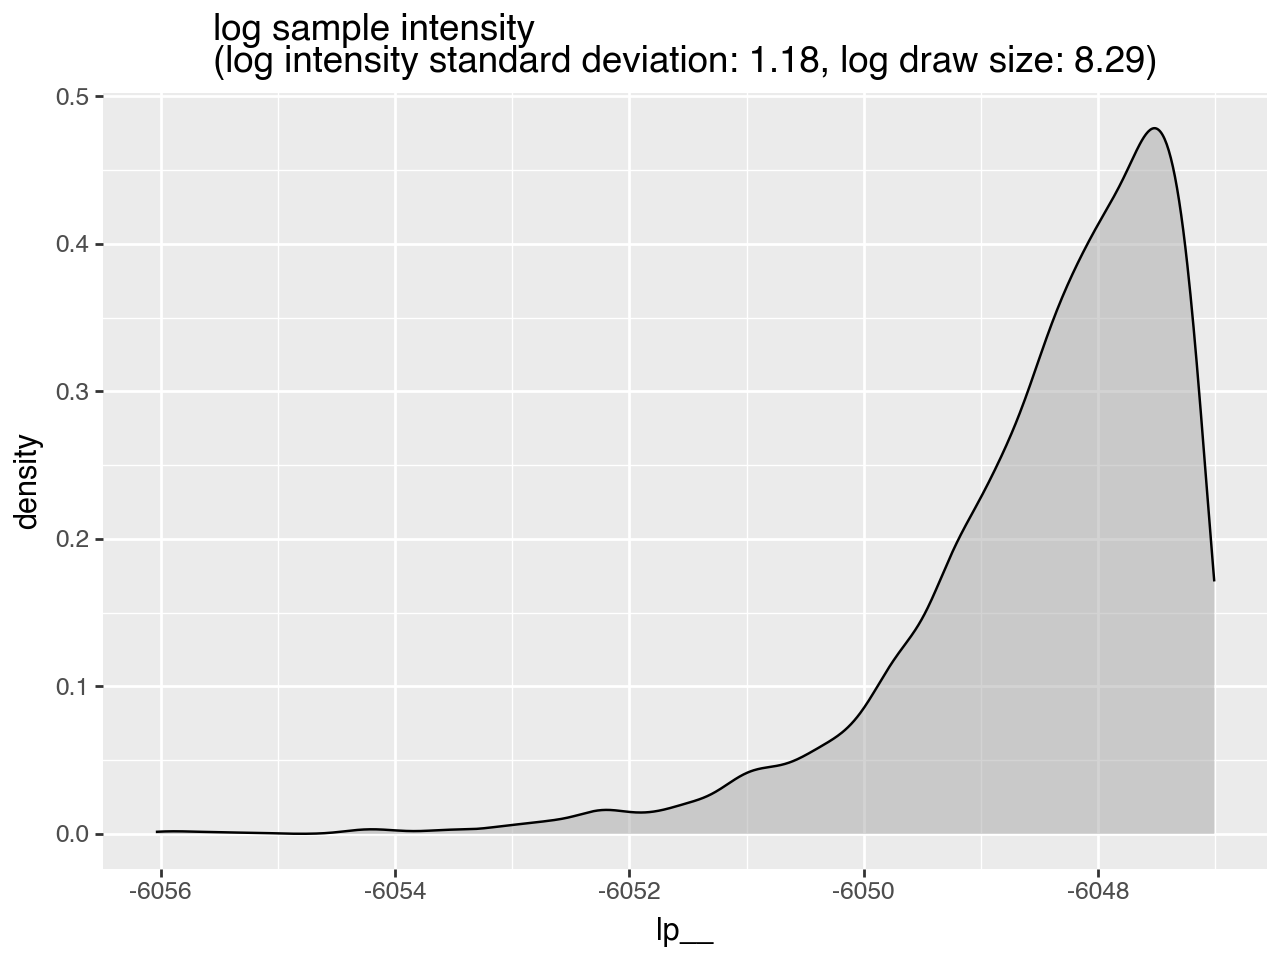

In [23]:
sd_sample_density = np.std(draws['lp__'])
log_draw_size = np.log(draws.shape[0])
(
    ggplot(
        data=draws,
        mapping=aes(x='lp__')
    )
    + geom_density(fill='darkgrey', alpha=0.5)
    + ggtitle(f"log sample intensity\n(log intensity standard deviation: {sd_sample_density:.2f}, log draw size: {log_draw_size:.2f})")
)

In [24]:
use_sample = draws['lp__'] >= np.quantile(draws['lp__'], 0.8)

In [25]:
coefs = np.array(
    draws.loc[use_sample, [f'beta[{var_j+1}]' for var_j in range(n_item_features)]].mean())

coefs

array([-0.05537996,  2.51601267])

In [26]:
beta_0 = np.mean(draws.loc[use_sample, 'beta_0'])

beta_0

-0.4258537431761787

In [27]:
def sigmoid(v):
    return 1 / (1 + np.exp(-v))

In [28]:
observations_test['Stan_score'] = sigmoid(beta_0 + observations_test.loc[:, variable_names] @ coefs)

In [29]:
observations_test.head()

,x1,x2,y,presentation_group,sampled_positive,unobservable_logistic_prediction,censored_logistic_prediction,Stan_score
0,-0.030772,0.914600,1,179,True,0.680026,0.475797,0.867266
1,1.012660,-0.003719,1,179,False,0.386532,0.032150,0.379589
2,-0.027100,-0.214783,0,179,False,0.313171,0.066438,0.275928
3,0.225265,0.095680,0,179,False,0.412534,0.095842,0.450761
4,-0.315568,-0.150670,0,179,False,0.330070,0.103837,0.312713


<Figure size 640x480 with 0 Axes>

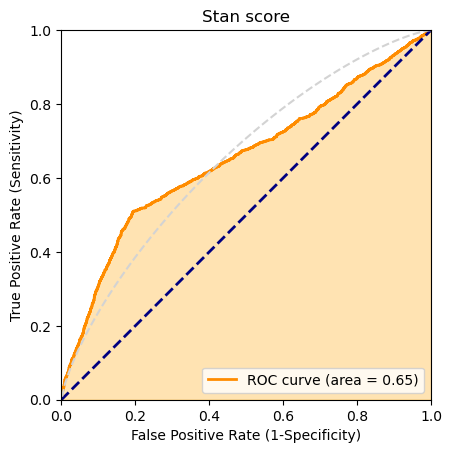

0.650974801186483

In [30]:
plot_roc(
    prediction=observations_test["Stan_score"],
    istrue=observations_test[score_name],
    ideal_line_color="lightgrey",
    title="Stan score",
)